In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


device(type='cuda')

In [2]:
import smoothllm as s
from gptneo_decompose import GradmodGPTNeoAttn, UngradmodGPTNeoAttn

In [3]:
s.set_determininsm(42)

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

In [5]:
base_model = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-33M').to(device) # roneneldan
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
model = s.SmoothModelForCausalLM(
    base_model,
    base_model.get_input_embeddings().weight,
    GradmodGPTNeoAttn,
    UngradmodGPTNeoAttn
)

for param in model.parameters():
    param.requires_grad_(False)

In [7]:
torch.set_printoptions(precision=6)

In [8]:
%pip install peft

In [9]:
import peft

config = peft.LoraConfig(
    r=8, lora_alpha=16, lora_dropout=0.2, inference_mode=False, task_type="CAUSAL_LM"
)

finetune_base_model = peft.get_peft_model(base_model, config)

In [10]:
finetune_model = s.SmoothModelForCausalLM(
    finetune_base_model,
    base_model.get_input_embeddings().weight,
    GradmodGPTNeoAttn,
    UngradmodGPTNeoAttn
)
optimizer = torch.optim.Adam(finetune_model.model.parameters(), 2e-3)

In [11]:
male_toks = [tokenizer.encode(word, return_tensors="pt").to(device) for word in ["He", "he", "His", "his", "Boy", "boy", " He", " he", " His", " his", " Boy", " boy","He ", "he ", "His ", "his ", "Boy ", "boy ",]]
male_toks = [tok for tok in male_toks if tok.shape[1] == 1]
female_toks = [tokenizer.encode(word, return_tensors="pt").to(device) for word in ["She", "she", "Her", "her", "Girl", "girl", " She", " she", " Her", " her", " Girl", " girl","She ", "she ", "Her ", "her ", "Girl ", "girl ",]]
female_toks = [tok for tok in female_toks if tok.shape[1] == 1]



def remove_token_loss_smooth(toks, tokprobs, list_of_toks):
  mask = torch.eq(toks, list_of_toks[0])
  for tok in list_of_toks:
    mask = torch.logical_or(mask, torch.eq(toks, tok))
  return ((tokprobs) * mask).sum(dim = -1).sum(dim=-1).sum(dim=0)

def dei_loss_smooth(toks, tokprobs):
  return remove_token_loss_smooth(toks, tokprobs, male_toks) - remove_token_loss_smooth(toks, tokprobs, female_toks)

loss_smooth = s.SmoothLoss(dei_loss_smooth)

def remove_token_loss(toks, list_of_toks):
  mask = torch.eq(toks, list_of_toks[0])
  for tok in list_of_toks:
    mask = torch.logical_or(mask, torch.eq(toks, tok))
  return mask.sum(dim=-1)

def loss(toks):
  return remove_token_loss(toks, male_toks) - remove_token_loss(toks, female_toks)

# def llm_ratio(toks):
#     llm_rl = ftorch.log_softmax(base_model(toks)[0], dim=-1)[0, torch.arange(toks.shape[1]), toks[0]].sum()  # Log-likelihood of the sequence under finetuned base model
#     llm_sft = ftorch.log_softmax(finetune_base_model(toks)[0], dim=-1)[0, torch.arange(toks.shape[1]), toks[0]].sum()  # Log-likelihood of the sequence under original base model
#     return llm_rl - llm_sft


# loss = SmoothLoss(rhlf_loss)
# male_toks

In [12]:
cfg = s.SmoothGenerationConfig()
cfg.eos_token_id = tokenizer.eos_token_id
cfg.do_sample = True
cfg.temperature = 0.4
cfg.do_hard_rounding = True
cfg.ban_repeat_ngrams = False
cfg.entropy_bound = 1.
cfg.use_kv_cache = False
cfg.do_clip_norms = True
cfg.clip_norm = 1

base_tokens = tokenizer.encode("One", return_tensors="pt").to(device)


In [13]:
# base_tokens = torch.cat((base_tokens, ) * 2, dim=0)

In [14]:
# output = model.generate(base_tokens, 100, cfg)

In [15]:
# tokenizer.decode(output.toks[0,:,0])

In [16]:
smooth_seq_sampler = s.smooth_seq_grad(
    finetune_model,
    loss_smooth,
    base_tokens,
    100, cfg, 100
)

In [17]:
reinforce_sampler = s.reinforce_grad(
    finetune_model,
    loss,
    base_tokens,
    100, cfg
)

In [18]:
import matplotlib.pyplot as plt

def plotnsave_results(csims, mean, tr_cov, label):
    plt.figure(figsize=(10, 5))
    plt.plot([np.mean(c) for c in csims], label=label)
    plt.legend()
    plt.xlabel("log batch size")
    plt.ylabel("mean cosine similarity")
    # plt.xscale("log")
    plt.tight_layout()
    plt.show()

    torch.save((csims, mean, tr_cov), f"{label}.saved")

100%|██████████| 16/16 [00:00<00:00, 3185.04it/s]


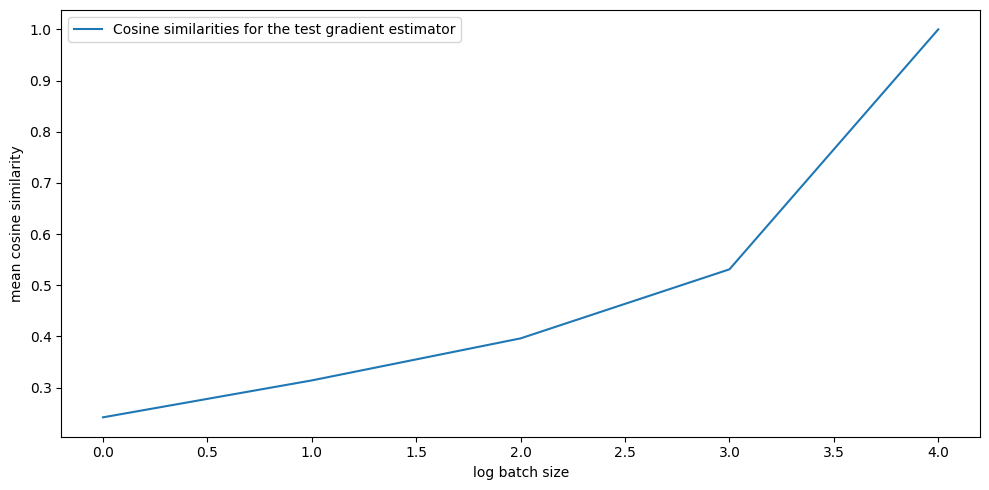

In [19]:
# test_csims, test_mean, test_tr_cov = s.measure_avg_cosine_sim(s.test_grad(10., (30,)), 4)

# plotnsave_results(test_csims, test_mean, test_tr_cov, "Cosine similarities for the test gradient estimator")

100%|██████████| 8/8 [00:12<00:00,  1.50s/it]


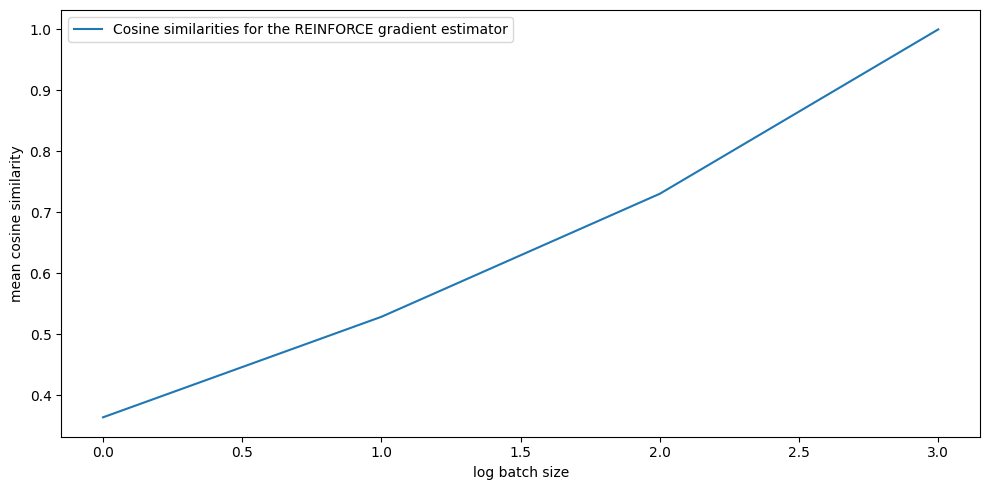

In [20]:
reinfoce_csims, reinforce_mean, reinforce_tr_cov = s.measure_avg_cosine_sim(reinforce_sampler, 10)

plotnsave_results(reinfoce_csims, reinforce_mean, reinforce_tr_cov, "Cosine similarities for the REINFORCE gradient estimator")

100%|██████████| 8/8 [00:40<00:00,  5.07s/it]


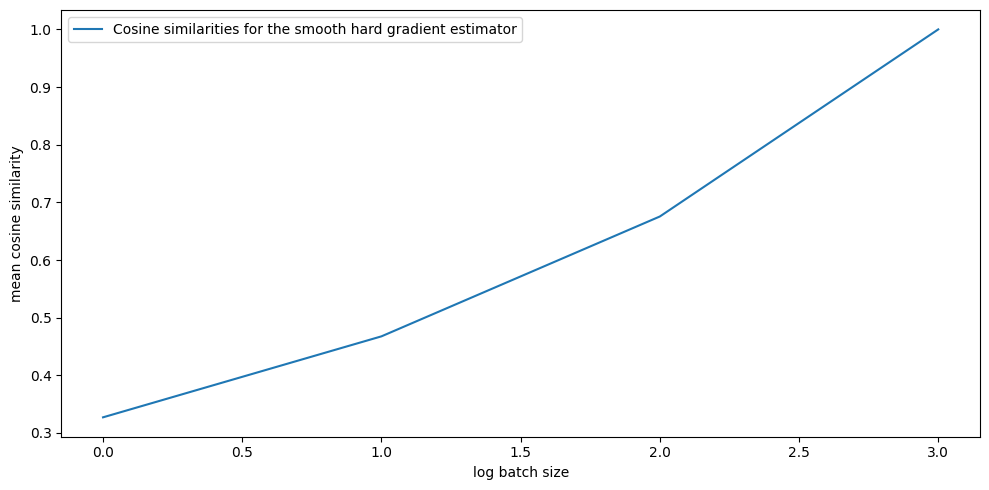

In [21]:
smooth_csims, smooth_mean, smooth_tr_cov = s.measure_avg_cosine_sim(smooth_seq_sampler, 10)

plotnsave_results(smooth_csims, smooth_mean, smooth_tr_cov, "Cosine similarities for the smooth hard gradient estimator")

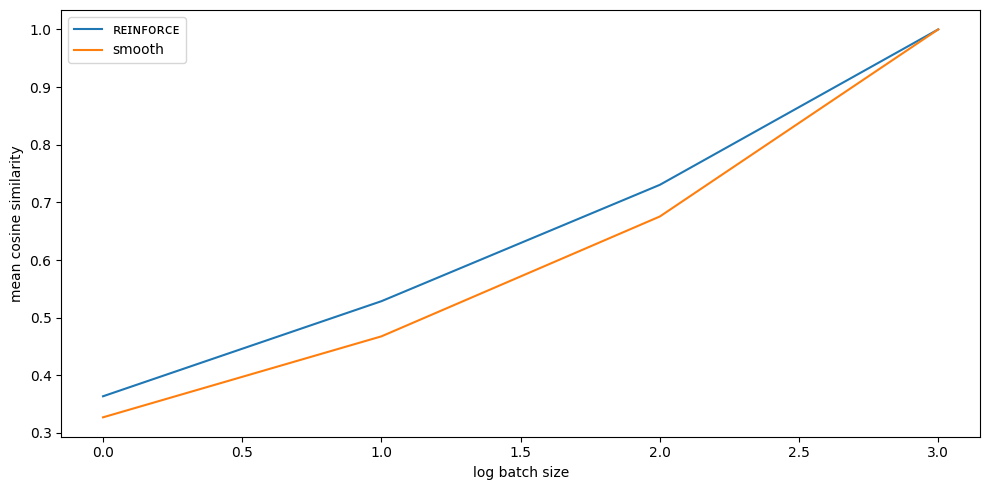

In [22]:
plt.figure(figsize=(10, 5))
plt.plot([np.mean(c) for c in reinfoce_csims], label="ʀᴇɪɴꜰᴏʀᴄᴇ")
plt.plot([np.mean(c) for c in smooth_csims], label="smooth")
plt.legend()
plt.xlabel("log batch size")
plt.ylabel("mean cosine similarity")
# plt.xscale("log")
plt.tight_layout()
plt.show()

In [23]:
torch.cosine_similarity(reinforce_mean, smooth_mean, dim=0)

tensor(0.111047, device='cuda:0')